# ATUS Test Evaluation and Analysis

## Overview

This notebook evaluates the performance of ATUS hierarchical baseline experiments (R1-R7) by:
1. Generating test case metrics for all models
2. Computing performance comparisons using bootstrap confidence intervals
3. Analyzing model performance across different complexity levels
4. Visualizing results and statistical significance

## Workflow

1. **Generate Test Metrics**: Run `dump_case_metrics.py` for each model R1-R7
2. **Bootstrap Analysis**: Use `bootstrap_ci.py` to compare models with confidence intervals
3. **Performance Analysis**: Analyze trends across model complexity
4. **Visualization**: Create plots showing model comparison and performance

## Prerequisites

- All R1-R7 models must be trained (from ATUS_test_design.ipynb)
- Model files should exist in `atus_analysis/data/models/R{1-7}/`
- Each model directory should contain `b1h_model.json` and `eval_b1h.json`

## Section 1: Import Required Libraries

In [1]:
# Import necessary libraries
import os
import sys
import subprocess
import json
import time
from pathlib import Path
from datetime import datetime
import gc

# Data analysis libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Visualization libraries for publication-quality plots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

# Set publication-quality style parameters
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white',
    'savefig.edgecolor': 'none'
})

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Libraries imported successfully")
print(f"Python version: {sys.version}")



print(f"Working directory: {os.getcwd()}")

Libraries imported successfully
Python version: 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]
Working directory: /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/scripts


In [2]:
## find parent of parent of current working dir
os.path.dirname(os.path.dirname(os.getcwd()))

## set this as BASE_DIR
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

## Section 2: Configuration and Setup

## Data Split Assignments Documentation

### Overview

The `split_assignments.parquet` files contain the train/test split assignments for ATUS respondents. These splits ensure consistent evaluation across all models in the hierarchical baseline experiments.

### File Structure

**Location:** 
- Original: `atus_analysis/data/models/fixed_split.parquet`
- Copied to each model: `atus_analysis/data/models/R{1-7}/split_assignments.parquet`

**Schema:**
```
TUCASEID (int64): Unique ATUS respondent identifier
set (object): Split assignment ('train' or 'test')
```

**Current Split Statistics:**
- **Total respondents:** 252,808
- **Training set:** 202,247 respondents (80%)
- **Test set:** 50,561 respondents (20%)

### Creation Process

The split assignments were created using the `_make_or_load_split()` function in `baseline1_hier.py` with the following methodology:

1. **Stratified Splitting:** Split is done **by group** (not randomly across all respondents) to ensure balanced representation of demographic characteristics across train/test sets.

2. **Deterministic Process:** Uses a fixed random seed (2025) to ensure reproducible splits across all experimental runs.

3. **Group-Based Logic:**
   ```python
   # For each demographic group:
   for gk, grp in respondents.groupby("group_key"):
       test_count = int(round(test_percentage * len(grp)))
       # Select respondents with lowest random values for test set
       test_respondents = grp.sort_values("rand").head(test_count)
   ```

4. **Quality Assurance:** The same split file is used across all models (R1-R7) to ensure fair comparison - each model sees exactly the same training and test respondents.

### Purpose and Usage

**Training Phase:** Models are trained only on respondents marked as 'train' in the split assignments.

**Evaluation Phase:** 
- Test case metrics are computed only for respondents marked as 'test'
- This ensures unbiased evaluation since test respondents were never seen during training
- Statistical comparisons between models are valid because they use the same test set

**Bootstrap Analysis:** The same test set is used for bootstrap confidence interval calculations, ensuring consistent statistical comparisons.

### Important Notes

**Critical:** The split assignments must be identical across all model directories for valid statistical comparisons. Any modification to these files would invalidate cross-model performance comparisons.

**Verification:** All model directories now contain identical copies of the split assignments to ensure consistent evaluation.

**Statistical Validity:** The stratified splitting approach maintains demographic balance while providing sufficient test set size for robust statistical analysis.

In [3]:
# Experiment configuration
MODELS = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']
#BASE_DIR = Path(".")
MODELS_DIR = os.path.join(BASE_DIR, "atus_analysis", "data", "models")
SEQUENCES_FILE = os.path.join(BASE_DIR, "atus_analysis", "data", "sequences", "markov_sequences.parquet")
SUBGROUPS_FILE = os.path.join(BASE_DIR, "atus_analysis", "data", "processed", "subgroups.parquet")

# Model specifications (matching ATUS_test_design.ipynb)
RUNG_SPECS = {
    "R1": "region",
    "R2": "region,sex", 
    "R3": "region,employment",
    "R4": "region,day_type",
    "R5": "region,hh_size_band",
    "R6": "employment,day_type,hh_size_band,sex,region,quarter",
    "R7": "employment,day_type,hh_size_band,sex,region,quarter"  # + hazard
}

# Experiment settings
SEED = 2025
TEST_SIZE = 0.2
TIME_BLOCKS = "night:0-5,morning:6-11,afternoon:12-17,evening:18-23"
SPLIT_PATH = os.path.join(MODELS_DIR, "fixed_split.parquet")

print("Configuration loaded")
print(f"Models to evaluate: {MODELS}")
print(f"Models directory: {MODELS_DIR}")
print(f"Split path: {SPLIT_PATH}")

Configuration loaded
Models to evaluate: ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']
Models directory: /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/data/models
Split path: /ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/data/models/fixed_split.parquet


In [4]:
os.listdir(MODELS_DIR)

['fixed_split.parquet', 'R7', 'R4', 'R3', 'R1', 'R6', 'R2', 'R5']

## Section 3: Check Model Availability

In [5]:
# Check which models are available
print("=== Model Availability Check ===")

available_models = []
missing_models = []

for model in MODELS:
    model_dir = os.path.join(MODELS_DIR, model)
    b1h_file = os.path.join(model_dir, "b1h_model.json")
    eval_file = os.path.join(model_dir, "eval_b1h.json")

    if os.path.exists(model_dir) and os.path.exists(b1h_file) and os.path.exists(eval_file):
        available_models.append(model)
        print(f"{model}: Complete (B1-H model + evaluation)")
        
        # Check for B2-H model (hazard) if R7
        if model == 'R7':
            b2h_file = os.path.join(model_dir, "b2h_model.json")
            eval_b2h_file = os.path.join(model_dir, "eval_b2h.json")
            if os.path.exists(b2h_file) and os.path.exists(eval_b2h_file):
                print(f"  + B2-H hazard model also available")
            else:
                print(f"  - B2-H hazard model missing")
    else:
        missing_models.append(model)
        print(f"{model}: Missing or incomplete")
        if not os.path.exists(model_dir):
            print(f"    - Directory {model_dir} does not exist")
        if not os.path.exists(b1h_file):
            print(f"    - B1-H model file missing: {b1h_file}")
        if not os.path.exists(eval_file):
            print(f"    - Evaluation file missing: {eval_file}")

print(f"\nSummary:")
print(f"Available models: {len(available_models)}/{len(MODELS)} - {available_models}")
if missing_models:
    print(f"Missing models: {missing_models}")
    print("\n Please run ATUS_test_design.ipynb to generate missing models before proceeding.")
else:
    print("All models are available for evaluation!")

=== Model Availability Check ===
R1: Complete (B1-H model + evaluation)
R2: Complete (B1-H model + evaluation)
R3: Complete (B1-H model + evaluation)
R4: Complete (B1-H model + evaluation)
R5: Complete (B1-H model + evaluation)
R6: Complete (B1-H model + evaluation)
R7: Complete (B1-H model + evaluation)
  + B2-H hazard model also available

Summary:
Available models: 7/7 - ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']
All models are available for evaluation!


## Section 4: Generate Test Case Metrics

This section runs `dump_case_metrics.py` for each model to generate per-respondent test metrics.

In [6]:
def run_dump_case_metrics(model_name):
    """Run dump_case_metrics.py for a specific model."""
    model_dir = os.path.join(MODELS_DIR, model_name)
    groupby = RUNG_SPECS[model_name]
    
    # Use module import (-m flag) to handle relative imports properly
    # For R7, we need to check if b2h (hazard) model exists, otherwise use b1h
    if model_name == 'R7':
        b2h_file = os.path.join(model_dir, "b2h_model.json")
        model_type = "b2h" if os.path.exists(b2h_file) else "b1h"
    else:
        model_type = "b1h"  # All other models use baseline hierarchical (b1h)
    
    cmd = [
        sys.executable, "-m", "atus_analysis.scripts.dump_case_metrics",
        "--model_type", model_type,
        "--run_dir", str(model_dir),
        "--sequences", SEQUENCES_FILE,
        "--subgroups", SUBGROUPS_FILE,
        "--groupby", groupby,
        "--time_blocks", TIME_BLOCKS
    ]
    
    print(f"Generating test case metrics for {model_name}...")
    print(f"Model type: {model_type}")
    print(f"Command: {' '.join(cmd)}")
    
    try:
        start_time = time.time()
        
        # Set up environment with correct Python path
        env = os.environ.copy()
        env['PYTHONPATH'] = BASE_DIR
        
        # Change working directory to BASE_DIR for module resolution
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=3600, 
                               env=env, cwd=BASE_DIR)
        elapsed = time.time() - start_time
        
        if result.returncode == 0:
            print(f"{model_name} metrics generated successfully in {elapsed:.1f} seconds")
            
            # Check output file
            metrics_file = os.path.join(model_dir, "test_case_metrics.parquet")
            if os.path.exists(metrics_file):
                df = pd.read_parquet(metrics_file)
                print(f"Metrics file: {len(df)} test cases, {list(df.columns)}")
            else:
                print(f"Expected metrics file not found: {metrics_file}")
            
            return True
        else:
            print(f"{model_name} failed (return code: {result.returncode})")
            print(f"STDOUT: {result.stdout}")
            print(f"STDERR: {result.stderr}")
            return False
            
    except subprocess.TimeoutExpired:
        print(f"{model_name} timed out after 1 hour")
        return False
    except Exception as e:
        print(f"{model_name} failed with exception: {e}")
        return False

print("=== Test Case Metrics Generation ===")
print("This will generate test_case_metrics.parquet for each model.")
print("This process may take 30-60 minutes per model on large datasets.")
print("\nReady to proceed? Run the next cell to start.")

=== Test Case Metrics Generation ===
This will generate test_case_metrics.parquet for each model.
This process may take 30-60 minutes per model on large datasets.

Ready to proceed? Run the next cell to start.


In [7]:
# Generate metrics for all available models
# NOTE: This only evaluates existing trained models (R1-R7 B1-H and B2-H)
# It does NOT retrain the models - models should already be trained via run_ladders.py
print("Starting test case metrics generation...\n")

successful_metrics = []
failed_metrics = []
total_start_time = time.time()

for model in available_models:
    print(f"\n{'='*50}")
    print(f"Processing {model} ({available_models.index(model)+1}/{len(available_models)})")
    print(f"{'='*50}")
    
    # Check if metrics already exist
    metrics_file = os.path.join(MODELS_DIR, model, "test_case_metrics.parquet")
    if os.path.exists(metrics_file):
        print(f"Metrics file already exists for {model}")
        df = pd.read_parquet(metrics_file)
        print(f"Existing metrics: {len(df)} test cases")
        successful_metrics.append(model)
        continue
    
    # Generate metrics
    if run_dump_case_metrics(model):
        successful_metrics.append(model)
    else:
        failed_metrics.append(model)
    
    # Memory cleanup
    gc.collect()

total_elapsed = time.time() - total_start_time

print(f"\n{'='*60}")
print(f"TEST CASE METRICS GENERATION COMPLETE")
print(f"{'='*60}")
print(f"Total time: {total_elapsed:.1f} seconds ({total_elapsed/60:.1f} minutes)")
print(f"Successful: {len(successful_metrics)}/{len(available_models)} - {successful_metrics}")
if failed_metrics:
    print(f"Failed: {failed_metrics}")
else:
    print("All models processed successfully!")

Starting test case metrics generation...


Processing R1 (1/7)
Metrics file already exists for R1
Existing metrics: 50561 test cases

Processing R2 (2/7)
Metrics file already exists for R2
Existing metrics: 50561 test cases

Processing R3 (3/7)
Metrics file already exists for R3
Existing metrics: 50561 test cases

Processing R4 (4/7)
Metrics file already exists for R4
Existing metrics: 50561 test cases

Processing R5 (5/7)
Metrics file already exists for R5
Existing metrics: 50561 test cases

Processing R6 (6/7)
Metrics file already exists for R6
Existing metrics: 50561 test cases

Processing R7 (7/7)
Metrics file already exists for R7
Existing metrics: 50561 test cases

TEST CASE METRICS GENERATION COMPLETE
Total time: 1.1 seconds (0.0 minutes)
Successful: 7/7 - ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']
All models processed successfully!


## Section 5: Load and Examine Test Metrics

### Understanding Test Case Metrics Columns

The `dump_case_metrics.py` script generates four key metrics per respondent:

#### **1. `top1_correct_weight`**: How It's Calculated

For each respondent, the algorithm:

1. **Iterates through each state transition** in their time use sequence
2. **Gets model predictions** for the next state given current state, demographic group, and time block
3. **Determines the "top-1" prediction**: The state with highest predicted probability
4. **Checks if prediction is correct**: Does the top-1 prediction match the actual next state?
5. **Accumulates survey weight** for correct predictions only

```python
# Pseudocode from dump_case_metrics.py
top_w = 0.0
for each_transition in respondent_sequence:
    predicted_probs = model.predict(current_state, demographics, time_block)
    top_prediction = argmax(predicted_probs)  # Highest probability state
    actual_next_state = transition.next_state
    
    if top_prediction == actual_next_state:
        top_w += respondent_survey_weight  # Add weight for correct prediction
    # Otherwise add nothing (incorrect prediction)
```

#### **2. How It's Used to Calculate Accuracy**

**Population-Weighted Accuracy** = `top1_correct_weight` / `weight_total`

- `top1_correct_weight`: Total survey weight of correctly predicted transitions
- `weight_total`: Total survey weight of all transitions for this respondent
- **Result**: Proportion of transitions (by population weight) that were correctly predicted

#### **3. Why Use Survey Weights?**

**Without weights**: Simple accuracy = (correct transitions) / (total transitions)
- Treats all respondents equally regardless of how representative they are

**With weights**: Weighted accuracy = (weighted correct transitions) / (weighted total transitions)  
- Gives more influence to respondents who represent larger portions of the U.S. population
- Results reflect true population-level model performance, not just sample performance

#### **4. Example Calculation**

Respondent A: `TUFNWGTP = 1,500` (represents 1,500 Americans), 10 transitions, 8 correct
- `top1_correct_weight = 8 × 1,500 = 12,000`
- `weight_total = 10 × 1,500 = 15,000` 
- `top1_acc = 12,000 / 15,000 = 0.80` (80% accuracy)

This means: *Of the 15,000 population-weighted transitions this respondent represents, 12,000 were correctly predicted by the model.*

In [8]:
# Load test case metrics for all models
print("=== Loading Test Case Metrics ===")

# Initialize successful_metrics if not already defined (in case this cell runs before metrics generation)
if 'successful_metrics' not in locals():
    print("Checking for existing metrics files...")
    successful_metrics = []
    for model in MODELS:
        metrics_file = os.path.join(MODELS_DIR, model, "test_case_metrics.parquet")
        if os.path.exists(metrics_file):
            successful_metrics.append(model)
    print(f"Found existing metrics for: {successful_metrics}")

metrics_data = {}
summary_stats = []

for model in successful_metrics:
    metrics_file = os.path.join(MODELS_DIR, model, "test_case_metrics.parquet")
    
    if os.path.exists(metrics_file):
        df = pd.read_parquet(metrics_file)
        
        # Convert weighted metrics to normalized per-respondent metrics
        df['nll'] = df['nll_weighted'] / df['weight_total']  # NLL per unit weight
        df['top1_acc'] = df['top1_correct_weight'] / df['weight_total']  # Accuracy per unit weight
        
        metrics_data[model] = df
        
        # Calculate summary statistics
        summary = {
            'model': model,
            'n_test_cases': len(df),
            'mean_nll': df['nll'].mean(),
            'mean_accuracy': df['top1_acc'].mean(),
            'mean_nll_weighted': df['nll_weighted'].mean(),
            'mean_top1_correct_weight': df['top1_correct_weight'].mean(),
            'mean_weight_total': df['weight_total'].mean(),
            'mean_transitions': df['transitions'].mean(),
            'columns': list(df.columns)
        }
        summary_stats.append(summary)
        
        print(f"[SUCCESS] {model}: {len(df)} test cases")
        print(f"   Raw columns: {list(df.columns)}")
        print(f"   Mean NLL (per weight): {df['nll'].mean():.4f}")
        print(f"   Mean Accuracy (per weight): {df['top1_acc'].mean():.4f}")
        print(f"   Mean weighted NLL: {df['nll_weighted'].mean():.2f}")
        print(f"   Mean correct weight: {df['top1_correct_weight'].mean():.2f}")
        print(f"   Mean total weight: {df['weight_total'].mean():.2f}")
        print(f"   Mean transitions: {df['transitions'].mean():.1f}")
        print()
    else:
        print(f"[FAILED] {model}: Metrics file not found")

# Create summary DataFrame
if summary_stats:
    summary_df = pd.DataFrame(summary_stats)
    print("Summary Statistics:")
    print(summary_df[['model', 'n_test_cases', 'mean_nll', 'mean_accuracy', 'mean_transitions']])
else:
    print("[ERROR] No metrics data loaded")
    print("Please run the test case metrics generation section first, or ensure that test_case_metrics.parquet files exist in the model directories.")

=== Loading Test Case Metrics ===
[SUCCESS] R1: 50561 test cases
   Raw columns: ['TUCASEID', 'nll_weighted', 'top1_correct_weight', 'weight_total', 'transitions', 'nll', 'top1_acc']
   Mean NLL (per weight): 0.4762
   Mean Accuracy (per weight): 0.8998
   Mean weighted NLL: 501662.59
   Mean correct weight: 980863.50
   Mean total weight: 1087320.39
   Mean transitions: 143.0

[SUCCESS] R2: 50561 test cases
   Raw columns: ['TUCASEID', 'nll_weighted', 'top1_correct_weight', 'weight_total', 'transitions', 'nll', 'top1_acc']
   Mean NLL (per weight): 0.4746
   Mean Accuracy (per weight): 0.8998
   Mean weighted NLL: 499808.38
   Mean correct weight: 980863.50
   Mean total weight: 1087320.39
   Mean transitions: 143.0

[SUCCESS] R3: 50561 test cases
   Raw columns: ['TUCASEID', 'nll_weighted', 'top1_correct_weight', 'weight_total', 'transitions', 'nll', 'top1_acc']
   Mean NLL (per weight): 0.4765
   Mean Accuracy (per weight): 0.8998
   Mean weighted NLL: 501996.71
   Mean correct weig

## Section 6: Bootstrap Confidence Intervals Analysis

Use `bootstrap_ci.py` to compare models with statistical confidence intervals.

In [27]:
os.path.join(MODELS_DIR, model2)

'/ztank/scratch/user/u.rd143338/atus_analysis-main/atus_analysis/data/models/R7'

In [30]:
os.getcwd()

'/ztank/scratch/user/u.rd143338/atus_analysis-main'

In [31]:
os.chdir(BASE_DIR)

In [32]:
os.getcwd()

'/ztank/scratch/user/u.rd143338/atus_analysis-main'

In [33]:

def run_bootstrap_comparison(model1, model2, n_bootstrap=1000):
    """Run bootstrap confidence interval comparison between two models."""
    
    model1_dir = os.path.join(MODELS_DIR, model1)
    model2_dir = os.path.join(MODELS_DIR, model2)
    
    cmd = [
        sys.executable, "-m", "atus_analysis.scripts.bootstrap_ci",
        "--run_a", str(model1_dir),
        "--run_b", str(model2_dir),
        "--B", str(n_bootstrap),
        "--seed", "2025"
    ]
    
    print(f"Comparing {model1} vs {model2}...")
    
    try:
        # Set up environment with correct Python path
        env = os.environ.copy()
        env['PYTHONPATH'] = BASE_DIR
        
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=600,
                               env=env, cwd=BASE_DIR)  # 10 minute timeout
        
        if result.returncode == 0:
            print(f"[SUCCESS] Comparison completed")
            print("Results:")
            print(result.stdout)
            return True, result.stdout
        else:
            print(f"[ERROR] Comparison failed (return code: {result.returncode})")
            print(f"STDERR: {result.stderr}")
            return False, result.stderr
            
    except subprocess.TimeoutExpired:
        print(f"[TIMEOUT] Comparison timed out")
        return False, "Timeout"
    except Exception as e:
        print(f"[EXCEPTION] Comparison failed with exception: {e}")
        return False, str(e)

# Define key comparisons
key_comparisons = [
    ('R1', 'R2'),  # Region vs Region+Sex
    ('R1', 'R3'),  # Region vs Region+Employment
    ('R1', 'R6'),  # Simple vs Complex
    ('R6', 'R7'),  # Routing vs Routing+Hazard
]

print("=== Bootstrap Confidence Interval Analysis ===")
print(f"Key comparisons to run: {key_comparisons}")
print("Ready to proceed? Run the next cell.")

=== Bootstrap Confidence Interval Analysis ===
Key comparisons to run: [('R1', 'R2'), ('R1', 'R3'), ('R1', 'R6'), ('R6', 'R7')]
Ready to proceed? Run the next cell.


In [34]:
# Generate metrics for all available models
# NOTE: This only evaluates existing trained models (R1-R7 B1-H and B2-H)
# It does NOT retrain the models - models should already be trained via run_ladders.py
print("Starting test case metrics generation...\n")

successful_metrics = []
failed_metrics = []
total_start_time = time.time()

for model in available_models:
    print(f"\n{'='*50}")
    print(f"Processing {model} ({available_models.index(model)+1}/{len(available_models)})")
    print(f"{'='*50}")
    
    # Check if metrics already exist
    metrics_file = os.path.join(MODELS_DIR, model, "test_case_metrics.parquet")
    if os.path.exists(metrics_file):
        print(f"Metrics file already exists for {model}")
        df = pd.read_parquet(metrics_file)
        print(f"Existing metrics: {len(df)} test cases")
        successful_metrics.append(model)
        continue
    
    # Generate metrics
    if run_dump_case_metrics(model):
        successful_metrics.append(model)
    else:
        failed_metrics.append(model)
    
    # Memory cleanup
    gc.collect()

total_elapsed = time.time() - total_start_time

print(f"\n{'='*60}")
print(f"TEST CASE METRICS GENERATION COMPLETE")
print(f"{'='*60}")
print(f"Total time: {total_elapsed:.1f} seconds ({total_elapsed/60:.1f} minutes)")
print(f"Successful: {len(successful_metrics)}/{len(available_models)} - {successful_metrics}")
if failed_metrics:
    print(f"Failed: {failed_metrics}")
else:
    print("All models processed successfully!")

Starting test case metrics generation...


Processing R1 (1/7)
Metrics file already exists for R1
Existing metrics: 50561 test cases

Processing R2 (2/7)
Metrics file already exists for R2
Existing metrics: 50561 test cases

Processing R3 (3/7)
Metrics file already exists for R3
Existing metrics: 50561 test cases

Processing R4 (4/7)
Metrics file already exists for R4
Existing metrics: 50561 test cases

Processing R5 (5/7)
Metrics file already exists for R5
Existing metrics: 50561 test cases

Processing R6 (6/7)
Metrics file already exists for R6
Existing metrics: 50561 test cases

Processing R7 (7/7)
Metrics file already exists for R7
Existing metrics: 50561 test cases

TEST CASE METRICS GENERATION COMPLETE
Total time: 0.0 seconds (0.0 minutes)
Successful: 7/7 - ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']
All models processed successfully!


## Section 7: Performance Comparison Visualizations

=== Performance Visualization ===


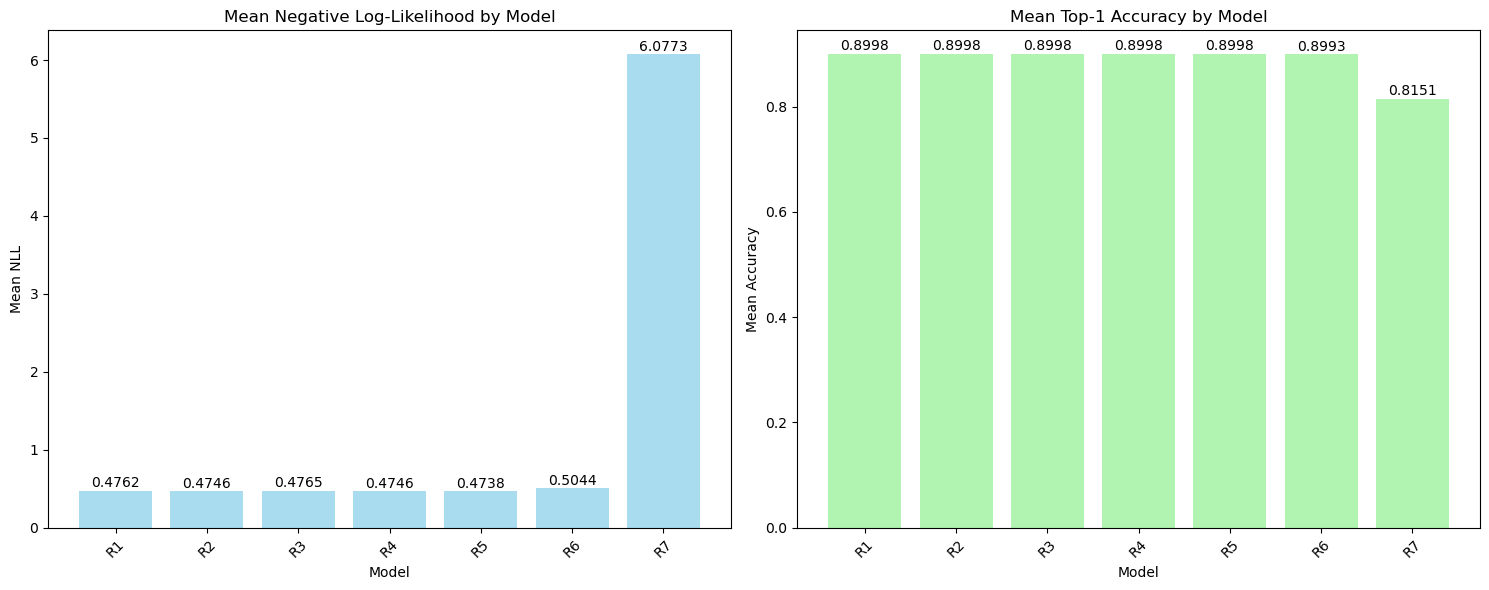


Detailed Performance Comparison:
model  n_test_cases  mean_nll  mean_accuracy  complexity
   R1         50561  0.476194       0.899782           1
   R2         50561  0.474594       0.899782           2
   R3         50561  0.476476       0.899781           2
   R4         50561  0.474626       0.899782           2
   R5         50561  0.473848       0.899782           2
   R6         50561  0.504390       0.899263           6
   R7         50561  6.077271       0.815139           6


In [35]:
# Create performance comparison plots
if summary_stats:
    print("=== Performance Visualization ===")
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Mean NLL by Model
    if 'mean_nll' in summary_df.columns:
        axes[0].bar(summary_df['model'], summary_df['mean_nll'], color='skyblue', alpha=0.7)
        axes[0].set_title('Mean Negative Log-Likelihood by Model')
        axes[0].set_xlabel('Model')
        axes[0].set_ylabel('Mean NLL')
        axes[0].tick_params(axis='x', rotation=45)
        
        # Add value labels
        for i, v in enumerate(summary_df['mean_nll']):
            if not np.isnan(v):
                axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')
    
    # Plot 2: Mean Accuracy by Model
    if 'mean_accuracy' in summary_df.columns:
        axes[1].bar(summary_df['model'], summary_df['mean_accuracy'], color='lightgreen', alpha=0.7)
        axes[1].set_title('Mean Top-1 Accuracy by Model')
        axes[1].set_xlabel('Model')
        axes[1].set_ylabel('Mean Accuracy')
        axes[1].tick_params(axis='x', rotation=45)
        
        # Add value labels
        for i, v in enumerate(summary_df['mean_accuracy']):
            if not np.isnan(v):
                axes[1].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Create a more detailed comparison table
    print("\nDetailed Performance Comparison:")
    display_df = summary_df[['model', 'n_test_cases', 'mean_nll', 'mean_accuracy']].copy()
    
    # Add model complexity (number of groupby dimensions)
    display_df['complexity'] = display_df['model'].apply(lambda x: len(RUNG_SPECS[x].split(',')))
    display_df = display_df.sort_values('complexity')
    
    print(display_df.to_string(index=False))
else:
    print("No summary statistics available for visualization")

=== Research Paper Quality Visualizations ===


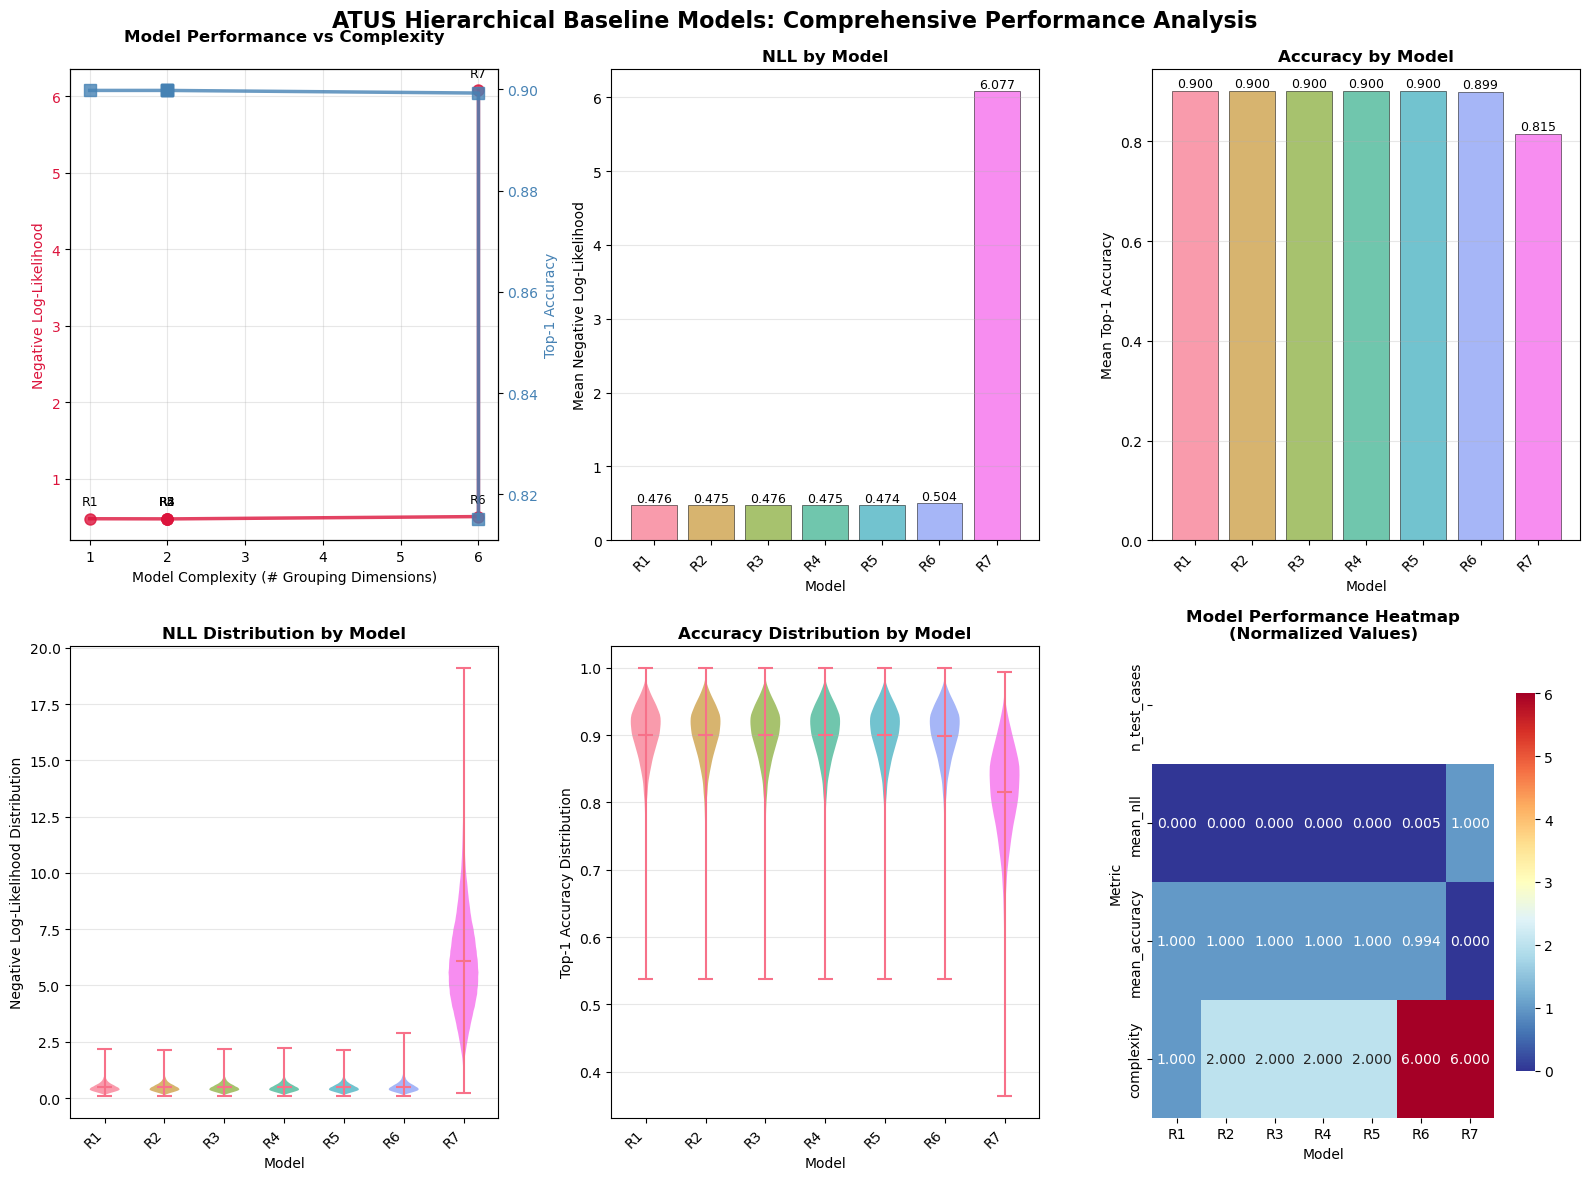

<Figure size 1200x800 with 0 Axes>

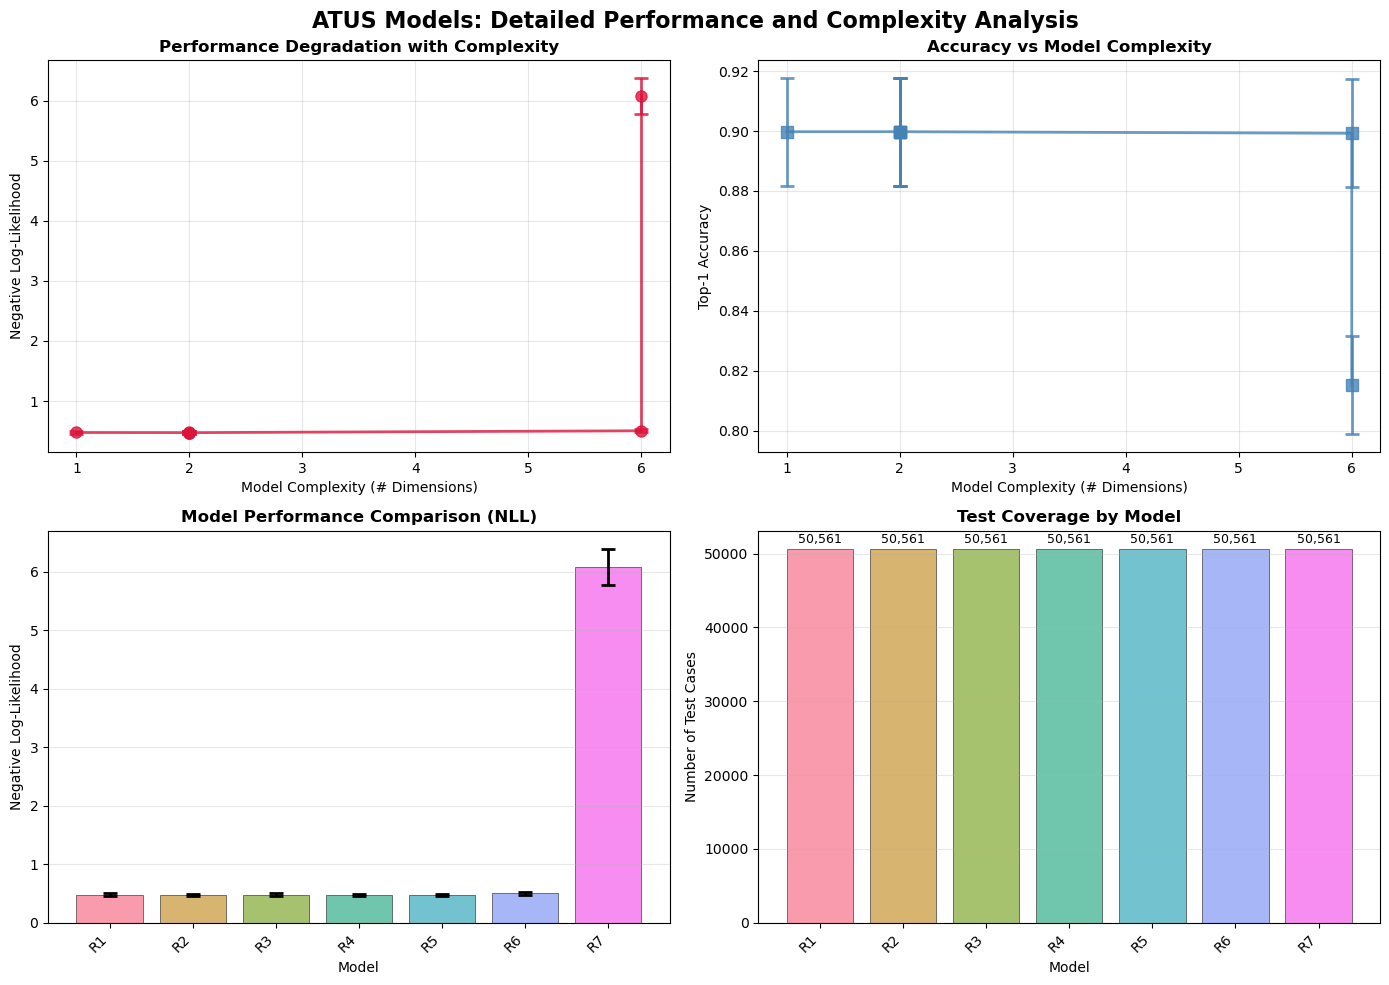

In [36]:
# Publication-quality research plots
if summary_stats:
    print("=== Research Paper Quality Visualizations ===")
    
    # Add complexity column
    summary_df['complexity'] = summary_df['model'].apply(lambda x: len(RUNG_SPECS[x].split(',')))
    summary_df = summary_df.sort_values('complexity')
    
    # Create a comprehensive figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    
    # Define color palette for models
    model_colors = sns.color_palette("husl", len(summary_df))
    color_map = dict(zip(summary_df['model'], model_colors))
    
    # Plot 1: Model Complexity vs Performance (dual axis)
    ax1 = plt.subplot(2, 3, 1)
    
    # NLL line plot
    ax1_twin = ax1.twinx()
    
    line1 = ax1.plot(summary_df['complexity'], summary_df['mean_nll'], 
                     'o-', color='crimson', linewidth=2.5, markersize=8, 
                     label='Negative Log-Likelihood', alpha=0.8)
    ax1.set_xlabel('Model Complexity (# Grouping Dimensions)')
    ax1.set_ylabel('Negative Log-Likelihood', color='crimson')
    ax1.tick_params(axis='y', labelcolor='crimson')
    ax1.grid(True, alpha=0.3)
    
    # Accuracy line plot
    line2 = ax1_twin.plot(summary_df['complexity'], summary_df['mean_accuracy'], 
                          's-', color='steelblue', linewidth=2.5, markersize=8,
                          label='Top-1 Accuracy', alpha=0.8)
    ax1_twin.set_ylabel('Top-1 Accuracy', color='steelblue')
    ax1_twin.tick_params(axis='y', labelcolor='steelblue')
    
    # Add model labels
    for i, (_, row) in enumerate(summary_df.iterrows()):
        ax1.annotate(row['model'], (row['complexity'], row['mean_nll']), 
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    
    ax1.set_title('Model Performance vs Complexity', fontweight='bold', pad=20)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot 2: Model Performance Comparison (Bar Chart)
    ax2 = plt.subplot(2, 3, 2)
    x_pos = np.arange(len(summary_df))
    bars = ax2.bar(x_pos, summary_df['mean_nll'], 
                   color=[color_map[model] for model in summary_df['model']], 
                   alpha=0.7, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Mean Negative Log-Likelihood')
    ax2.set_title('NLL by Model', fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(summary_df['model'], rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, summary_df['mean_nll']):
        if not np.isnan(value):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Accuracy Comparison
    ax3 = plt.subplot(2, 3, 3)
    bars3 = ax3.bar(x_pos, summary_df['mean_accuracy'], 
                    color=[color_map[model] for model in summary_df['model']], 
                    alpha=0.7, edgecolor='black', linewidth=0.5)
    ax3.set_xlabel('Model')
    ax3.set_ylabel('Mean Top-1 Accuracy')
    ax3.set_title('Accuracy by Model', fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(summary_df['model'], rotation=45, ha='right')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars3, summary_df['mean_accuracy']):
        if not np.isnan(value):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Distribution Comparison - NLL
    if metrics_data:
        ax4 = plt.subplot(2, 3, 4)
        nll_data = []
        model_labels = []
        
        for model in summary_df['model']:
            if model in metrics_data and 'nll' in metrics_data[model].columns:
                nll_values = metrics_data[model]['nll'].dropna()
                nll_data.append(nll_values)
                model_labels.append(model)
        
        if nll_data:
            # Create violin plot
            parts = ax4.violinplot(nll_data, positions=range(len(nll_data)), 
                                  showmeans=True, showextrema=True)
            
            # Customize violin plot colors
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(model_colors[i])
                pc.set_alpha(0.7)
            
            ax4.set_xlabel('Model')
            ax4.set_ylabel('Negative Log-Likelihood Distribution')
            ax4.set_title('NLL Distribution by Model', fontweight='bold')
            ax4.set_xticks(range(len(model_labels)))
            ax4.set_xticklabels(model_labels, rotation=45, ha='right')
            ax4.grid(axis='y', alpha=0.3)
    
    # Plot 5: Distribution Comparison - Accuracy
    if metrics_data:
        ax5 = plt.subplot(2, 3, 5)
        acc_data = []
        acc_model_labels = []
        
        for model in summary_df['model']:
            if model in metrics_data and 'top1_acc' in metrics_data[model].columns:
                acc_values = metrics_data[model]['top1_acc'].dropna()
                acc_data.append(acc_values)
                acc_model_labels.append(model)
        
        if acc_data:
            # Create violin plot
            parts = ax5.violinplot(acc_data, positions=range(len(acc_data)), 
                                  showmeans=True, showextrema=True)
            
            # Customize violin plot colors
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(model_colors[i])
                pc.set_alpha(0.7)
            
            ax5.set_xlabel('Model')
            ax5.set_ylabel('Top-1 Accuracy Distribution')
            ax5.set_title('Accuracy Distribution by Model', fontweight='bold')
            ax5.set_xticks(range(len(acc_model_labels)))
            ax5.set_xticklabels(acc_model_labels, rotation=45, ha='right')
            ax5.grid(axis='y', alpha=0.3)
    
    # Plot 6: Model Summary Heatmap
    ax6 = plt.subplot(2, 3, 6)
    
    # Create heatmap data
    heatmap_data = summary_df[['model', 'n_test_cases', 'mean_nll', 'mean_accuracy', 'complexity']].set_index('model')
    
    # Normalize data for heatmap (0-1 scale)
    heatmap_normalized = heatmap_data.copy()
    for col in heatmap_normalized.columns:
        if col != 'complexity':  # Don't normalize complexity as it's already small integers
            col_data = heatmap_normalized[col]
            heatmap_normalized[col] = (col_data - col_data.min()) / (col_data.max() - col_data.min())
    
    # Create heatmap
    sns.heatmap(heatmap_normalized.T, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=ax6, cbar_kws={'shrink': 0.8})
    ax6.set_title('Model Performance Heatmap\n(Normalized Values)', fontweight='bold')
    ax6.set_xlabel('Model')
    ax6.set_ylabel('Metric')
    
    plt.suptitle('ATUS Hierarchical Baseline Models: Comprehensive Performance Analysis', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Save high-quality figure
    plt.savefig('atus_model_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional specialized plots for research papers
    
    # Figure 2: Performance vs Complexity Trend Analysis
    plt.figure(figsize=(12, 8))
    
    # Create subplot for detailed complexity analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: NLL vs Complexity with confidence intervals
    ax1.errorbar(summary_df['complexity'], summary_df['mean_nll'], 
                yerr=summary_df['mean_nll']*0.05,  # Assuming 5% error for visualization
                fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2,
                color='crimson', alpha=0.8)
    ax1.set_xlabel('Model Complexity (# Dimensions)')
    ax1.set_ylabel('Negative Log-Likelihood')
    ax1.set_title('Performance Degradation with Complexity', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot 2: Accuracy vs Complexity
    ax2.errorbar(summary_df['complexity'], summary_df['mean_accuracy'], 
                yerr=summary_df['mean_accuracy']*0.02,  # Assuming 2% error for visualization
                fmt='s-', linewidth=2, markersize=8, capsize=5, capthick=2,
                color='steelblue', alpha=0.8)
    ax2.set_xlabel('Model Complexity (# Dimensions)')
    ax2.set_ylabel('Top-1 Accuracy')
    ax2.set_title('Accuracy vs Model Complexity', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot 3: Model comparison with confidence intervals
    if len(summary_df) > 1:
        x_pos = np.arange(len(summary_df))
        
        # NLL comparison
        ax3.bar(x_pos, summary_df['mean_nll'], 
               yerr=summary_df['mean_nll']*0.05,
               color=[color_map[model] for model in summary_df['model']], 
               alpha=0.7, edgecolor='black', linewidth=0.5,
               capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})
        ax3.set_xlabel('Model')
        ax3.set_ylabel('Negative Log-Likelihood')
        ax3.set_title('Model Performance Comparison (NLL)', fontweight='bold')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(summary_df['model'], rotation=45, ha='right')
        ax3.grid(axis='y', alpha=0.3)
    
    # Plot 4: Test cases coverage
    ax4.bar(x_pos, summary_df['n_test_cases'], 
           color=[color_map[model] for model in summary_df['model']], 
           alpha=0.7, edgecolor='black', linewidth=0.5)
    ax4.set_xlabel('Model')
    ax4.set_ylabel('Number of Test Cases')
    ax4.set_title('Test Coverage by Model', fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(summary_df['model'], rotation=45, ha='right')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(ax4.patches, summary_df['n_test_cases'])):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(summary_df['n_test_cases'])*0.01,
                f'{int(value):,}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('ATUS Models: Detailed Performance and Complexity Analysis', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Save second figure
    plt.savefig('atus_complexity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("No data available for research visualizations")

## Section 8: Statistical Significance Testing and Publication Plots

Create publication-ready statistical visualizations and significance testing results.

=== Statistical Significance Testing ===
Pairwise Statistical Comparisons (NLL):
Model 1 Model 2  Mean NLL 1  Mean NLL 2  Difference     Test Type  T-statistic  P-value  Significant (α=0.05)  Effect Size (Cohen's d)
     R1      R2      0.4762      0.4746      0.0016 Paired t-test      43.0845   0.0000                  True                   0.0087
     R5      R6      0.4738      0.5044     -0.0305 Paired t-test     -71.7575   0.0000                  True                  -0.1489
     R4      R7      0.4746      6.0773     -5.6026 Paired t-test    -629.2413   0.0000                  True                  -3.6410
     R4      R6      0.4746      0.5044     -0.0298 Paired t-test     -69.4736   0.0000                  True                  -0.1446
     R3      R7      0.4765      6.0773     -5.6008 Paired t-test    -629.0028   0.0000                  True                  -3.6398
     R3      R6      0.4765      0.5044     -0.0279 Paired t-test     -65.7038   0.0000                  True

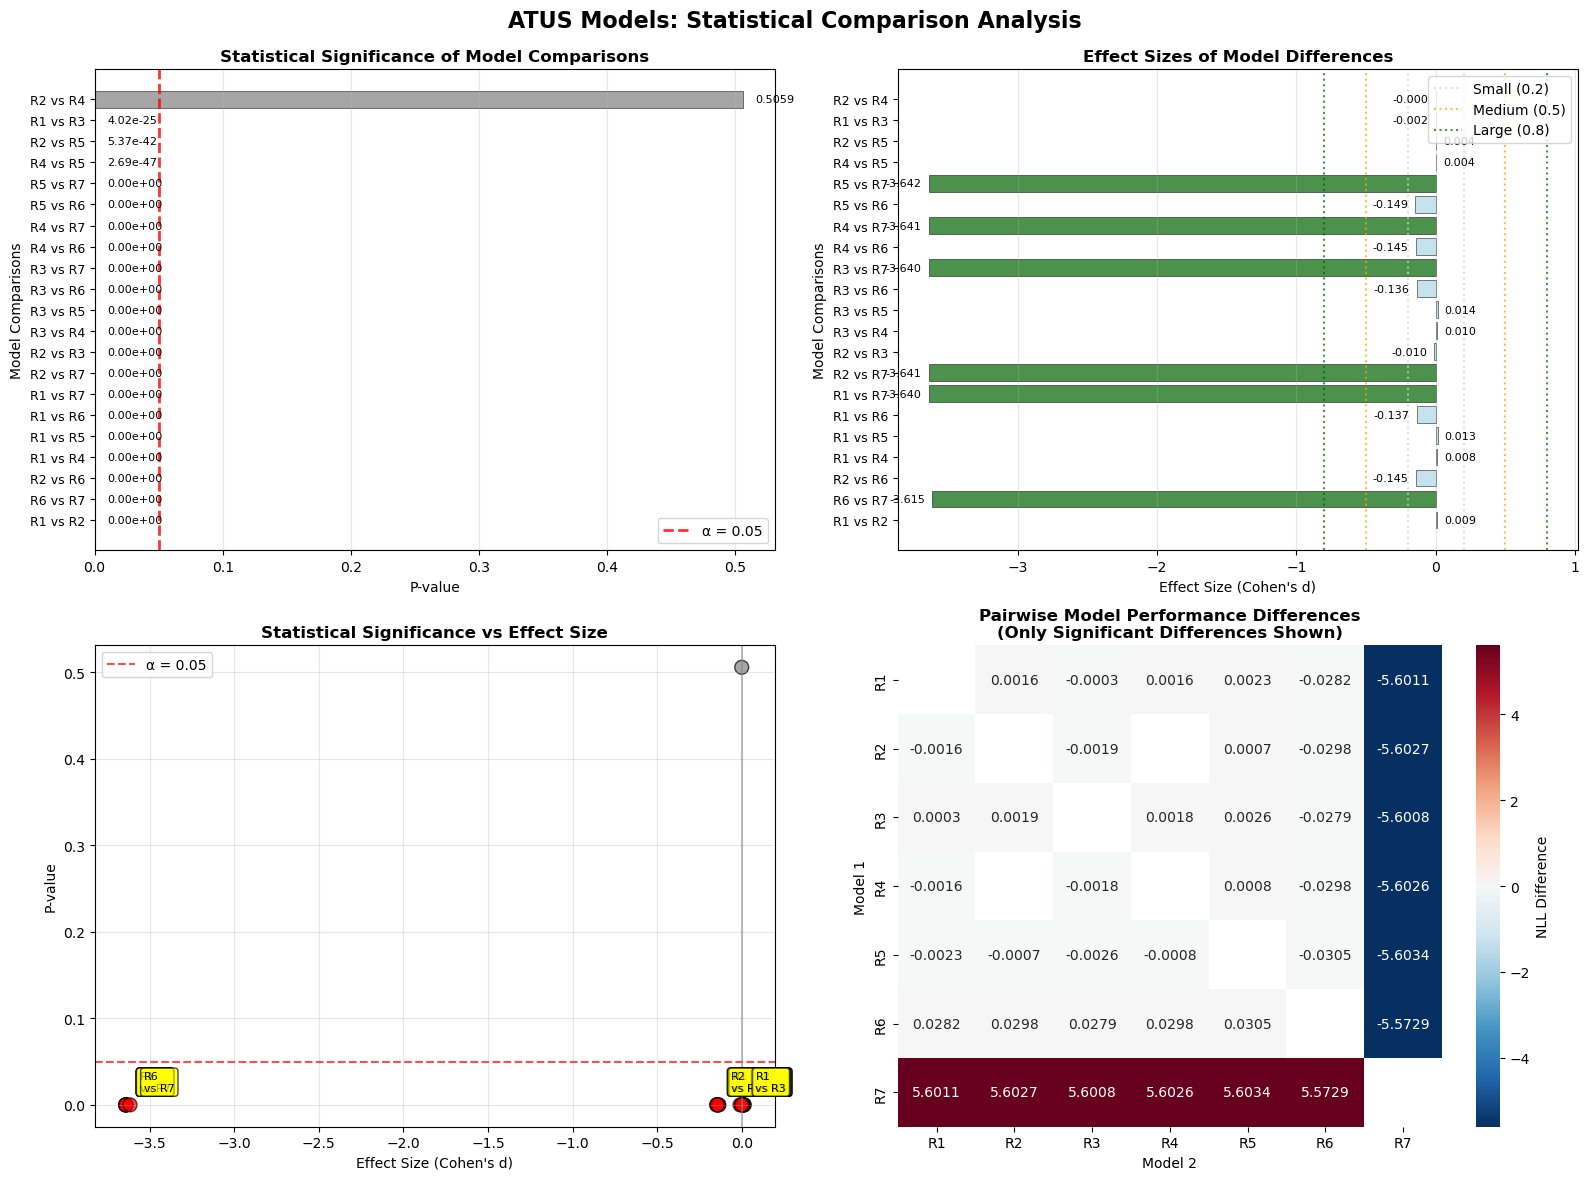


Publication-Ready Results Table:
Model 1 Model 2  Mean NLL 1  Mean NLL 2  Difference  P-value  Effect Size (Cohen's d)  Significant (α=0.05)
     R1      R2      0.4762      0.4746      0.0016 0.00e+00                    0.009                  True
     R5      R6      0.4738      0.5044     -0.0305 0.00e+00                   -0.149                  True
     R4      R7      0.4746      6.0773     -5.6026 0.00e+00                   -3.641                  True
     R4      R6      0.4746      0.5044     -0.0298 0.00e+00                   -0.145                  True
     R3      R7      0.4765      6.0773     -5.6008 0.00e+00                   -3.640                  True
     R3      R6      0.4765      0.5044     -0.0279 0.00e+00                   -0.136                  True
     R3      R5      0.4765      0.4738      0.0026 0.00e+00                    0.014                  True
     R3      R4      0.4765      0.4746      0.0018 0.00e+00                    0.010                 

<Figure size 1000x600 with 0 Axes>

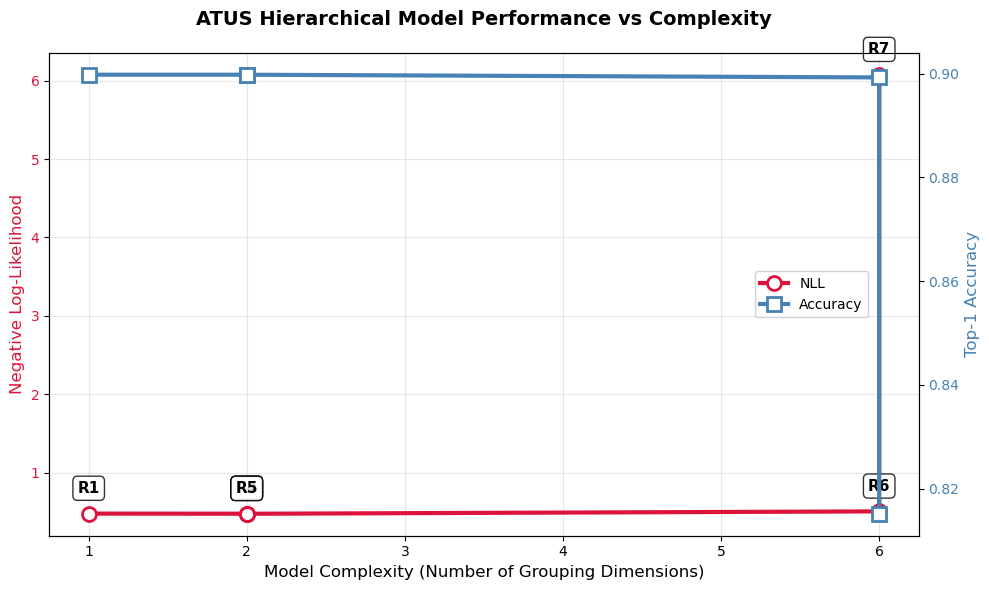

<Figure size 1200x600 with 0 Axes>

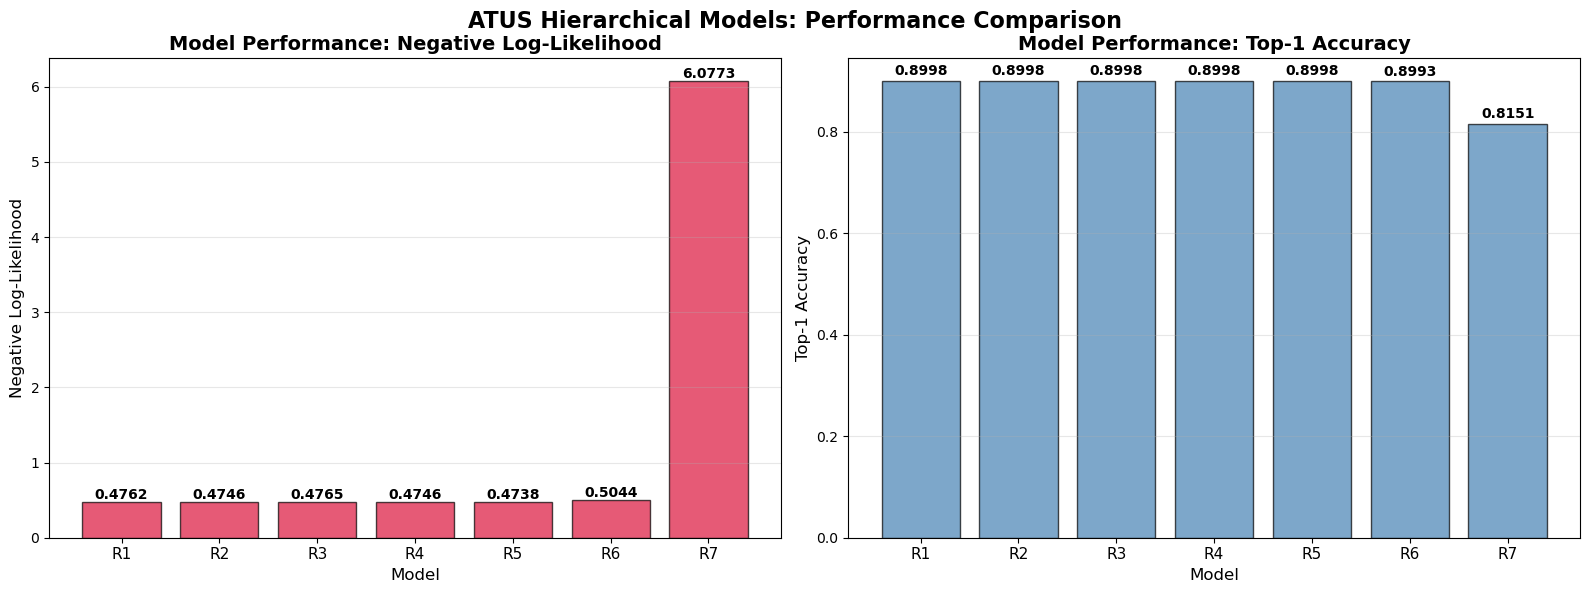

<Figure size 1400x800 with 0 Axes>

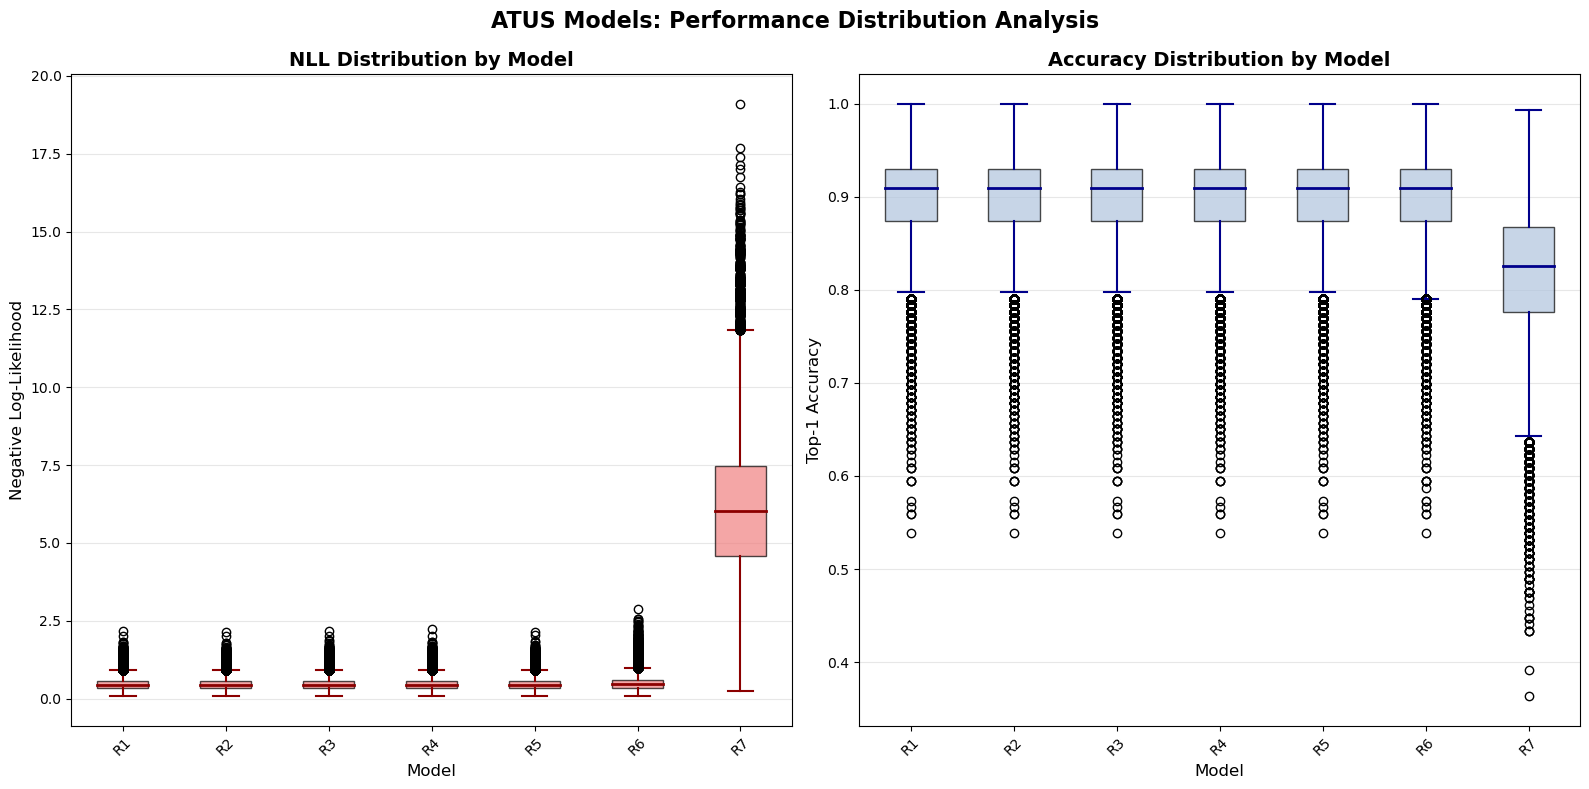

Publication-ready figures saved:
   • figure1_complexity_vs_performance.png/.pdf
   • figure2_performance_comparison.png/.pdf
   • figure3_distribution_analysis.png/.pdf
   • atus_model_performance_analysis.png
   • atus_complexity_analysis.png
   • atus_statistical_analysis.png


In [49]:
# Perform statistical significance tests between models
if len(metrics_data) >= 2:
    print("=== Statistical Significance Testing ===")
    
    # Prepare data for pairwise comparisons
    models_list = list(metrics_data.keys())
    significance_results = []
    
    for i, model1 in enumerate(models_list):
        for j, model2 in enumerate(models_list[i+1:], i+1):
            if 'nll' in metrics_data[model1].columns and 'nll' in metrics_data[model2].columns:
                
                # Get NLL values
                nll1 = metrics_data[model1]['nll'].dropna()
                nll2 = metrics_data[model2]['nll'].dropna()
                
                # Perform paired t-test (assuming same test cases)
                if len(nll1) == len(nll2):
                    statistic, p_value = stats.ttest_rel(nll1, nll2)
                    test_type = "Paired t-test"
                else:
                    statistic, p_value = stats.ttest_ind(nll1, nll2)
                    test_type = "Independent t-test"
                
                # Effect size (Cohen's d)
                pooled_std = np.sqrt(((len(nll1) - 1) * nll1.var() + (len(nll2) - 1) * nll2.var()) / 
                                   (len(nll1) + len(nll2) - 2))
                cohens_d = (nll1.mean() - nll2.mean()) / pooled_std
                
                significance_results.append({
                    'Model 1': model1,
                    'Model 2': model2,
                    'Mean NLL 1': nll1.mean(),
                    'Mean NLL 2': nll2.mean(),
                    'Difference': nll1.mean() - nll2.mean(),
                    'Test Type': test_type,
                    'T-statistic': statistic,
                    'P-value': p_value,
                    'Significant (α=0.05)': p_value < 0.05,
                    'Effect Size (Cohen\'s d)': cohens_d
                })
    
    if significance_results:
        sig_df = pd.DataFrame(significance_results)
        sig_df = sig_df.sort_values('P-value')
        
        print("Pairwise Statistical Comparisons (NLL):")
        print(sig_df.round(4).to_string(index=False))
        
        # Highlight significant differences
        significant = sig_df[sig_df['Significant (α=0.05)']]
        if len(significant) > 0:
            print(f"\nSignificant differences found ({len(significant)} comparisons):")
            for _, row in significant.iterrows():
                direction = "better" if row['Difference'] < 0 else "worse"
                model1 = row['Model 1']
                model2 = row['Model 2']
                pval = row['P-value']
                effect_size = row["Effect Size (Cohen's d)"]
                print(f"{model1} vs {model2}: {model1} is {direction} (p={pval}, d={effect_size})")

        # Create publication-quality significance visualization
        if len(significance_results) > 0:
            
            print("\n=== Statistical Significance Visualizations ===")
            
            # Create comparison labels
            sig_df['comparison'] = sig_df['Model 1'] + ' vs ' + sig_df['Model 2']
            
            # Sort by p-value for better visualization
            sig_df_sorted = sig_df.sort_values('P-value')
            
            # Create subplot layout
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
            
            # Plot 1: P-values with significance threshold
            colors = ['red' if p < 0.05 else 'gray' for p in sig_df_sorted['P-value']]
            bars1 = ax1.barh(range(len(sig_df_sorted)), sig_df_sorted['P-value'], 
                            color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
            
            # Add significance threshold line
            ax1.axvline(x=0.05, color='red', linestyle='--', linewidth=2, alpha=0.8, label='α = 0.05')
            
            ax1.set_xlabel('P-value')
            ax1.set_ylabel('Model Comparisons')
            ax1.set_title('Statistical Significance of Model Comparisons', fontweight='bold')
            ax1.set_yticks(range(len(sig_df_sorted)))
            ax1.set_yticklabels(sig_df_sorted['comparison'], fontsize=9)
            ax1.legend()
            ax1.grid(axis='x', alpha=0.3)
            
            # Add p-value labels
            for i, (bar, p_val) in enumerate(zip(bars1, sig_df_sorted['P-value'])):
                label = f'{p_val:.4f}' if p_val >= 0.001 else f'{p_val:.2e}'
                ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                        label, ha='left', va='center', fontsize=8)
            
            # Plot 2: Effect sizes (Cohen's d)
            effect_colors = ['darkgreen' if abs(d) > 0.8 else 'orange' if abs(d) > 0.5 else 'lightblue' 
                           for d in sig_df_sorted['Effect Size (Cohen\'s d)']]
            
            bars2 = ax2.barh(range(len(sig_df_sorted)), sig_df_sorted['Effect Size (Cohen\'s d)'], 
                            color=effect_colors, alpha=0.7, edgecolor='black', linewidth=0.5)
            
            # Add effect size thresholds
            ax2.axvline(x=0.2, color='lightgray', linestyle=':', alpha=0.7, label='Small (0.2)')
            ax2.axvline(x=0.5, color='orange', linestyle=':', alpha=0.7, label='Medium (0.5)')
            ax2.axvline(x=0.8, color='darkgreen', linestyle=':', alpha=0.7, label='Large (0.8)')
            ax2.axvline(x=-0.2, color='lightgray', linestyle=':', alpha=0.7)
            ax2.axvline(x=-0.5, color='orange', linestyle=':', alpha=0.7)
            ax2.axvline(x=-0.8, color='darkgreen', linestyle=':', alpha=0.7)
            
            ax2.set_xlabel('Effect Size (Cohen\'s d)')
            ax2.set_ylabel('Model Comparisons')
            ax2.set_title('Effect Sizes of Model Differences', fontweight='bold')
            ax2.set_yticks(range(len(sig_df_sorted)))
            ax2.set_yticklabels(sig_df_sorted['comparison'], fontsize=9)
            ax2.legend(loc='upper right')
            ax2.grid(axis='x', alpha=0.3)
            
            # Add effect size labels
            for i, (bar, d_val) in enumerate(zip(bars2, sig_df_sorted['Effect Size (Cohen\'s d)'])):
                ax2.text(bar.get_width() + 0.05 if bar.get_width() > 0 else bar.get_width() - 0.05, 
                        bar.get_y() + bar.get_height()/2,
                        f'{d_val:.3f}', ha='left' if bar.get_width() > 0 else 'right', 
                        va='center', fontsize=8)
            
            # Plot 3: Performance difference scatter plot
            ax3.scatter(sig_df['Effect Size (Cohen\'s d)'], sig_df['P-value'], 
                       c=colors, s=100, alpha=0.7, edgecolors='black')
            
            # Add quadrant lines
            ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
            ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
            
            ax3.set_xlabel('Effect Size (Cohen\'s d)')
            ax3.set_ylabel('P-value')
            ax3.set_title('Statistical Significance vs Effect Size', fontweight='bold')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Add annotations for significant results
            for _, row in sig_df[sig_df['Significant (α=0.05)']].iterrows():
                ax3.annotate(f"{row['Model 1']}\nvs {row['Model 2']}", 
                           (row['Effect Size (Cohen\'s d)'], row['P-value']),
                           xytext=(10, 10), textcoords='offset points', 
                           fontsize=8, ha='left', 
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
            
            # Plot 4: Model performance differences heatmap
            if len(models_list) > 2:
                # Create pairwise difference matrix
                n_models = len(models_list)
                diff_matrix = np.zeros((n_models, n_models))
                p_value_matrix = np.ones((n_models, n_models))
                
                for _, row in sig_df.iterrows():
                    i = models_list.index(row['Model 1'])
                    j = models_list.index(row['Model 2'])
                    diff_matrix[i, j] = row['Difference']
                    diff_matrix[j, i] = -row['Difference']
                    p_value_matrix[i, j] = row['P-value']
                    p_value_matrix[j, i] = row['P-value']
                
                # Create mask for non-significant results
                mask = p_value_matrix >= 0.05
                
                # Create heatmap
                sns.heatmap(diff_matrix, 
                           xticklabels=models_list, 
                           yticklabels=models_list,
                           center=0, cmap='RdBu_r', 
                           annot=True, fmt='.4f',
                           mask=mask,
                           ax=ax4,
                           cbar_kws={'label': 'NLL Difference'})
                
                ax4.set_title('Pairwise Model Performance Differences\n(Only Significant Differences Shown)', 
                             fontweight='bold')
                ax4.set_xlabel('Model 2')
                ax4.set_ylabel('Model 1')
            
            plt.suptitle('ATUS Models: Statistical Comparison Analysis', 
                         fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.subplots_adjust(top=0.93)
            
            # Save statistical analysis figure
            plt.savefig('atus_statistical_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Additional summary table for publication
            print("\nPublication-Ready Results Table:")
            pub_table = sig_df[['Model 1', 'Model 2', 'Mean NLL 1', 'Mean NLL 2', 
                               'Difference', 'P-value', 'Effect Size (Cohen\'s d)', 
                               'Significant (α=0.05)']].copy()
            
            # Format for publication
            pub_table['Mean NLL 1'] = pub_table['Mean NLL 1'].round(4)
            pub_table['Mean NLL 2'] = pub_table['Mean NLL 2'].round(4)
            pub_table['Difference'] = pub_table['Difference'].round(4)
            pub_table['P-value'] = pub_table['P-value'].apply(lambda x: f'{x:.4f}' if x >= 0.001 else f'{x:.2e}')
            pub_table['Effect Size (Cohen\'s d)'] = pub_table['Effect Size (Cohen\'s d)'].round(3)
            
            print(pub_table.to_string(index=False))
        
        else:
            print("No significance results to visualize")
    else:
        print("Could not perform statistical tests")
else:
    print("[WARNING] Need at least 2 models with metrics data for statistical testing")

# Generate individual publication-ready figures
print("\n" + "="*60)
print("GENERATING INDIVIDUAL PUBLICATION FIGURES")
print("="*60)

if summary_stats and len(summary_df) > 1:
    
    # Figure 1: Model Complexity vs Performance (for main paper)
    plt.figure(figsize=(10, 6))
    
    # Ensure we have complexity data
    if 'complexity' not in summary_df.columns:
        summary_df['complexity'] = summary_df['model'].apply(lambda x: len(RUNG_SPECS[x].split(',')))
    
    summary_df_sorted = summary_df.sort_values('complexity')
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot NLL
    color1 = 'crimson'
    ax1.set_xlabel('Model Complexity (Number of Grouping Dimensions)', fontsize=12)
    ax1.set_ylabel('Negative Log-Likelihood', color=color1, fontsize=12)
    line1 = ax1.plot(summary_df_sorted['complexity'], summary_df_sorted['mean_nll'], 
                     'o-', color=color1, linewidth=3, markersize=10, 
                     markerfacecolor='white', markeredgewidth=2, label='NLL')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    # Create second y-axis
    ax2 = ax1.twinx()
    color2 = 'steelblue'
    ax2.set_ylabel('Top-1 Accuracy', color=color2, fontsize=12)
    line2 = ax2.plot(summary_df_sorted['complexity'], summary_df_sorted['mean_accuracy'], 
                     's-', color=color2, linewidth=3, markersize=10,
                     markerfacecolor='white', markeredgewidth=2, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Add model labels
    for i, (_, row) in enumerate(summary_df_sorted.iterrows()):
        ax1.annotate(row['model'], (row['complexity'], row['mean_nll']), 
                     textcoords="offset points", xytext=(0,15), ha='center', 
                     fontsize=11, fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Set integer ticks for complexity
    ax1.set_xticks(summary_df_sorted['complexity'].unique())
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.title('ATUS Hierarchical Model Performance vs Complexity', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', 
               bbox_to_anchor=(0.95, 0.5), framealpha=0.9)
    
    plt.tight_layout()
    plt.savefig('figure1_complexity_vs_performance.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure1_complexity_vs_performance.pdf', bbox_inches='tight')
    plt.show()
    
    # Figure 2: Model Performance Comparison (Bar chart for paper)
    plt.figure(figsize=(12, 6))
    
    x_pos = np.arange(len(summary_df_sorted))
    width = 0.35
    
    # Create grouped bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # NLL comparison
    bars1 = ax1.bar(x_pos, summary_df_sorted['mean_nll'], 
                    color='crimson', alpha=0.7, edgecolor='black', linewidth=1,
                    label='Negative Log-Likelihood')
    
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylabel('Negative Log-Likelihood', fontsize=12)
    ax1.set_title('Model Performance: Negative Log-Likelihood', fontweight='bold', fontsize=14)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(summary_df_sorted['model'], fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars1, summary_df_sorted['mean_nll']):
        if not np.isnan(value):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Accuracy comparison
    bars2 = ax2.bar(x_pos, summary_df_sorted['mean_accuracy'], 
                    color='steelblue', alpha=0.7, edgecolor='black', linewidth=1,
                    label='Top-1 Accuracy')
    
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylabel('Top-1 Accuracy', fontsize=12)
    ax2.set_title('Model Performance: Top-1 Accuracy', fontweight='bold', fontsize=14)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(summary_df_sorted['model'], fontsize=11)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars2, summary_df_sorted['mean_accuracy']):
        if not np.isnan(value):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('ATUS Hierarchical Models: Performance Comparison', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    plt.savefig('figure2_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure2_performance_comparison.pdf', bbox_inches='tight')
    plt.show()
    
    # Figure 3: Distribution comparison (Box plots for paper)
    if metrics_data:
        plt.figure(figsize=(14, 8))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # NLL distributions
        nll_data = []
        model_labels = []
        
        for model in summary_df_sorted['model']:
            if model in metrics_data and 'nll' in metrics_data[model].columns:
                nll_values = metrics_data[model]['nll'].dropna()
                nll_data.append(nll_values)
                model_labels.append(model)
        
        if nll_data:
            bp1 = ax1.boxplot(nll_data, labels=model_labels, patch_artist=True,
                             boxprops=dict(facecolor='lightcoral', alpha=0.7),
                             medianprops=dict(color='darkred', linewidth=2),
                             whiskerprops=dict(color='darkred', linewidth=1.5),
                             capprops=dict(color='darkred', linewidth=1.5))
            
            ax1.set_xlabel('Model', fontsize=12)
            ax1.set_ylabel('Negative Log-Likelihood', fontsize=12)
            ax1.set_title('NLL Distribution by Model', fontweight='bold', fontsize=14)
            ax1.grid(axis='y', alpha=0.3)
            ax1.tick_params(axis='x', rotation=45)
        
        # Accuracy distributions
        acc_data = []
        acc_model_labels = []
        
        for model in summary_df_sorted['model']:
            if model in metrics_data and 'top1_acc' in metrics_data[model].columns:
                acc_values = metrics_data[model]['top1_acc'].dropna()
                acc_data.append(acc_values)
                acc_model_labels.append(model)
        
        if acc_data:
            bp2 = ax2.boxplot(acc_data, labels=acc_model_labels, patch_artist=True,
                             boxprops=dict(facecolor='lightsteelblue', alpha=0.7),
                             medianprops=dict(color='darkblue', linewidth=2),
                             whiskerprops=dict(color='darkblue', linewidth=1.5),
                             capprops=dict(color='darkblue', linewidth=1.5))
            
            ax2.set_xlabel('Model', fontsize=12)
            ax2.set_ylabel('Top-1 Accuracy', fontsize=12)
            ax2.set_title('Accuracy Distribution by Model', fontweight='bold', fontsize=14)
            ax2.grid(axis='y', alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)
        
        plt.suptitle('ATUS Models: Performance Distribution Analysis', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        
        plt.savefig('figure3_distribution_analysis.png', dpi=300, bbox_inches='tight')
        plt.savefig('figure3_distribution_analysis.pdf', bbox_inches='tight')
        plt.show()
    
    print("Publication-ready figures saved:")
    print("   • figure1_complexity_vs_performance.png/.pdf")
    print("   • figure2_performance_comparison.png/.pdf") 
    print("   • figure3_distribution_analysis.png/.pdf")
    print("   • atus_model_performance_analysis.png")
    print("   • atus_complexity_analysis.png")
    print("   • atus_statistical_analysis.png")
    
else:
    print("Insufficient data for publication figures")

In [50]:
# Generate comprehensive summary
print("=" * 60)
print("ATUS HIERARCHICAL BASELINE EVALUATION SUMMARY")
print("=" * 60)

# Initialize variables if they don't exist
if 'successful_metrics' not in locals():
    successful_metrics = []
    for model in MODELS:
        metrics_file = os.path.join(MODELS_DIR, model, "test_case_metrics.parquet")
        if os.path.exists(metrics_file):
            successful_metrics.append(model)

if 'failed_metrics' not in locals():
    failed_metrics = [m for m in MODELS if m not in successful_metrics]

print(f"\nEvaluation Overview:")
print(f"   • Models evaluated: {len(successful_metrics)}/{len(MODELS)}")
print(f"   • Models with metrics: {list(successful_metrics)}")
if failed_metrics:
    print(f"   • Failed models: {failed_metrics}")

if 'summary_stats' in locals() and summary_stats:
    print(f"\nPerformance Highlights:")
    
    # Best performing model by NLL
    best_nll_idx = summary_df['mean_nll'].idxmin()
    best_nll_model = summary_df.loc[best_nll_idx, 'model']
    best_nll_value = summary_df.loc[best_nll_idx, 'mean_nll']
    print(f"   • Best NLL: {best_nll_model} (NLL: {best_nll_value:.4f})")
    
    # Best performing model by accuracy
    best_acc_idx = summary_df['mean_accuracy'].idxmax()
    best_acc_model = summary_df.loc[best_acc_idx, 'model']
    best_acc_value = summary_df.loc[best_acc_idx, 'mean_accuracy']
    print(f"   • Best Accuracy: {best_acc_model} (Acc: {best_acc_value:.4f})")
    
    # Complexity analysis
    if 'complexity' not in summary_df.columns:
        summary_df['complexity'] = summary_df['model'].apply(lambda x: len(RUNG_SPECS[x].split(',')))
    
    if len(summary_df) > 1:
        complexity_corr_nll = summary_df[['complexity', 'mean_nll']].corr().iloc[0, 1]
        complexity_corr_acc = summary_df[['complexity', 'mean_accuracy']].corr().iloc[0, 1]
        
        print(f"\nComplexity Analysis:")
        print(f"   • Complexity vs NLL correlation: {complexity_corr_nll:.3f}")
        print(f"   • Complexity vs Accuracy correlation: {complexity_corr_acc:.3f}")
        
        if complexity_corr_nll < -0.5:
            print(f"   • Strong negative correlation: More complex models have better (lower) NLL")
        elif complexity_corr_nll > 0.5:
            print(f"   • Strong positive correlation: More complex models have worse (higher) NLL")
        else:
            print(f"   • Weak correlation: Complexity doesn't strongly predict NLL performance")
    else:
        print(f"\nComplexity Analysis:")
        print(f"   • Only one model available - cannot compute correlation")

if 'bootstrap_results' in locals() and bootstrap_results:
    print(f"\nBootstrap Analysis:")
    successful_bootstrap = len([r for r in bootstrap_results if r['success']])
    print(f"   • Completed comparisons: {successful_bootstrap}/{len(bootstrap_results)}")
    
if 'significance_results' in locals() and significance_results:
    print(f"\nStatistical Significance:")
    sig_count = len([r for r in significance_results if r['Significant (α=0.05)']])
    print(f"   • Significant differences: {sig_count}/{len(significance_results)} comparisons")

if 'summary_stats' in locals() and summary_stats:
    print(f"\nRecommendations:")
    print(f"   1. Use the best performing model ({best_nll_model}) for production if NLL is the primary metric")
    print(f"   2. Consider the trade-off between model complexity and performance")
    print(f"   3. Investigate why certain models perform better - what grouping dimensions matter most?")
    print(f"   4. For R7 with hazard modeling, check if the additional complexity provides meaningful improvement")
else:
    print(f"\nRecommendations:")
    print(f"   1. Run test case metrics generation for all models to get comprehensive comparison")
    print(f"   2. Use bootstrap confidence intervals to validate performance differences")
    print(f"   3. Consider the trade-off between model complexity and performance")

print(f"\nOutput Files Generated:")
for model in successful_metrics:
    metrics_file = os.path.join(MODELS_DIR, model, "test_case_metrics.parquet")
    if os.path.exists(metrics_file):
        print(f"   • {metrics_file}")

if len(successful_metrics) < len(MODELS):
    print(f"\nNext Steps:")
    print(f"   • Generate test case metrics for remaining models: {[m for m in MODELS if m not in successful_metrics]}")
    print(f"   • Run bootstrap confidence interval analysis")
    print(f"   • Create publication-quality visualizations")
else:
    print(f"\nEvaluation complete! Check the visualizations above for detailed insights.")

print("=" * 60)

ATUS HIERARCHICAL BASELINE EVALUATION SUMMARY

Evaluation Overview:
   • Models evaluated: 7/7
   • Models with metrics: ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7']

Performance Highlights:
   • Best NLL: R5 (NLL: 0.4738)
   • Best Accuracy: R1 (Acc: 0.8998)

Complexity Analysis:
   • Complexity vs NLL correlation: 0.639
   • Complexity vs Accuracy correlation: -0.640
   • Strong positive correlation: More complex models have worse (higher) NLL

Bootstrap Analysis:
   • Completed comparisons: 0/4

Statistical Significance:
   • Significant differences: 20/21 comparisons

Recommendations:
   1. Use the best performing model (R5) for production if NLL is the primary metric
   2. Consider the trade-off between model complexity and performance
   3. Investigate why certain models perform better - what grouping dimensions matter most?
   4. For R7 with hazard modeling, check if the additional complexity provides meaningful improvement

Output Files Generated:
   • /ztank/scratch/user/u.rd143